In [15]:
import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [16]:
import sklearn.datasets
wine = sklearn.datasets.load_wine()
wine.data.shape, wine.target.shape

((178, 13), (178,))

In [17]:
wine.data[0]

array([1.423e+01, 1.710e+00, 2.430e+00, 1.560e+01, 1.270e+02, 2.800e+00,
       3.060e+00, 2.800e-01, 2.290e+00, 5.640e+00, 1.040e+00, 3.920e+00,
       1.065e+03])

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    wine.data[:, :2], # для удобства визуализации
    wine.target, 
    test_size=0.3, # 30 проц выборки в тест
    shuffle=True)

X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

In [19]:
class WineNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super(WineNet, self).__init__()
        
        self.fc1 = torch.nn.Linear(2, n_hidden_neurons)
        self.activ1 = torch.nn.Sigmoid()

        # self.fc2 = torch.nn.Linear(n_hidden_neurons, n_hidden_neurons)
        # self.activ2 = torch.nn.Sigmoid()

        self.fc3 = torch.nn.Linear(n_hidden_neurons, 3) # потому что 3 класса

        self.sm = torch.nn.Softmax(dim=1) # получим вероятности классов
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.activ1(x)
        # x = self.fc2(x)
        # x = self.activ2(x)
        x = self.fc3(x)
        # нет Softmax!
        # потому что CrossEntropyLoss считается без Softmax
        return x

    def inference(self, x): # для вероятностей
        x = self.forward(x)
        x = self.sm(x)
        return x
    
wine_net = WineNet(5)

In [20]:
loss = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(wine_net.parameters(), lr=1.0e-3)

In [21]:
np.random.permutation(5) 
# можем взять индексы в случайном порядке

array([2, 0, 1, 4, 3])

In [22]:
batch_size = 10

for epoch in range(5000):

    order = np.random.permutation(len(X_train)) # перемешивает датасет 

    for start_index in range(0, len(X_train), batch_size):

        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        x_batch = X_train[batch_indexes]
        y_batch = y_train[batch_indexes]
        
        preds = wine_net.forward(x_batch) 
        
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        
        optimizer.step()
        
    if epoch % 100 == 0:
        test_preds = wine_net.forward(X_test)
        test_preds = test_preds.argmax(dim=1) # какой класс с масимальной веротностью
        print((test_preds == y_test).float().mean()) # доля совпадений

tensor(0.4074)
tensor(0.5000)
tensor(0.4630)
tensor(0.4630)
tensor(0.4630)
tensor(0.5556)
tensor(0.5370)
tensor(0.7222)
tensor(0.7222)
tensor(0.7778)
tensor(0.7963)
tensor(0.7778)
tensor(0.7778)
tensor(0.7778)
tensor(0.7963)
tensor(0.7963)
tensor(0.8148)
tensor(0.8148)
tensor(0.8148)
tensor(0.8333)
tensor(0.8333)
tensor(0.8333)
tensor(0.8519)
tensor(0.8519)
tensor(0.8519)
tensor(0.8519)
tensor(0.8519)
tensor(0.8704)
tensor(0.8704)
tensor(0.8519)
tensor(0.8704)
tensor(0.8704)
tensor(0.8889)
tensor(0.8704)
tensor(0.9074)
tensor(0.8889)
tensor(0.9074)
tensor(0.9074)
tensor(0.9074)
tensor(0.8889)
tensor(0.9074)
tensor(0.9074)
tensor(0.9074)
tensor(0.9074)
tensor(0.9074)
tensor(0.8889)
tensor(0.9074)
tensor(0.9074)
tensor(0.8704)
tensor(0.9074)


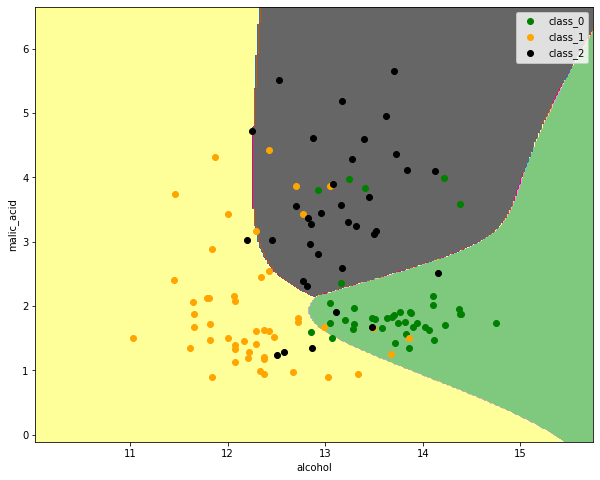

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (10, 8)

n_classes = 3
plot_colors = ['g', 'orange', 'black']
plot_step = 0.02

x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1

xx, yy =  torch.meshgrid(torch.arange(x_min, x_max, plot_step),
                         torch.arange(y_min, y_max, plot_step))

preds = wine_net.inference(
    torch.cat([xx.reshape(-1, 1), yy.reshape(-1, 1)], dim=1))

preds_class = preds.data.numpy().argmax(axis=1)
preds_class = preds_class.reshape(xx.shape)
plt.contourf(xx, yy, preds_class, cmap='Accent')

for i, color in zip(range(n_classes), plot_colors):
    indexes = np.where(y_train == i)
    plt.scatter(X_train[indexes, 0], 
                X_train[indexes, 1], 
                c=color, 
                label=wine.target_names[i],
                cmap='Accent')
    plt.xlabel(wine.feature_names[0])
    plt.ylabel(wine.feature_names[1])
    plt.legend()

Давайте попрактикуемся с WineNet. Измените архитектуру так, чтобы на вход принимались все 13 признаков и проведите следующие эксперименты:

1. Поэкспериментируйте с количеством нейронов в скрытых слоях. Попробуйте поставить очень маленькое число. Существует ли пороговое значение количества скрытых нейронов, при котором обучение становится невозможным?

2. Попробуйте передавать различные значения test_size в функцию train_test_split. При каком значении test_size сеть предсказывает хуже чем Base Rate*? И какой Base Rate у датасета вин?

3. Зависит ли время обучения на одной эпохе от размера батча? Исследуйте эту зависимость.

In [50]:
np.shape(X_train)

torch.Size([124, 13])

In [53]:
X_train, X_test, y_train, y_test = train_test_split(
    wine.data, wine.target, test_size=0.3, shuffle=True)

X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

class WineNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super(WineNet, self).__init__()
        
        self.fc1 = torch.nn.Linear(13, n_hidden_neurons)
        self.activ1 = torch.nn.Sigmoid()

        self.fc2 = torch.nn.Linear(n_hidden_neurons, n_hidden_neurons)
        self.activ2 = torch.nn.Sigmoid()

        self.fc3 = torch.nn.Linear(n_hidden_neurons, 3) # потому что 3 класса

        self.sm = torch.nn.Softmax(dim=1) # получим вероятности классов
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.activ1(x)
        x = self.fc2(x)
        x = self.activ2(x)
        x = self.fc3(x)
        # нет Softmax! потому что CrossEntropyLoss считается без Softmax, + стофтмакс "тяжелый"
        return x

    def inference(self, x): # для вероятностей
        x = self.forward(x)
        x = self.sm(x)
        return x
    
wine_net = WineNet(5)

loss = torch.nn.CrossEntropyLoss()
arr_loss = []

optimizer = torch.optim.Adam(wine_net.parameters(), lr=1.0e-3)

batch_size = 50

for epoch in range(5000):

    order = np.random.permutation(len(X_train)) # перемешивает датасет 

    for start_index in range(0, len(X_train), batch_size):

        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        x_batch = X_train[batch_indexes]
        y_batch = y_train[batch_indexes]
        
        preds = wine_net.forward(x_batch) 
        
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        
        optimizer.step()
        
    if epoch % 100 == 0:
        test_preds = wine_net.forward(X_test)
        test_preds = test_preds.argmax(dim=1) # какой класс с масимальной веротностью
        arr_loss.append((test_preds == y_test).float().mean())
        print((test_preds == y_test).float().mean()) # доля совпадений

tensor(0.2593)
tensor(0.2593)
tensor(0.6481)
tensor(0.6667)
tensor(0.6667)
tensor(0.6667)
tensor(0.7037)
tensor(0.7037)
tensor(0.7037)
tensor(0.7222)
tensor(0.7222)
tensor(0.7222)
tensor(0.7222)
tensor(0.7222)
tensor(0.7222)
tensor(0.7222)
tensor(0.7222)
tensor(0.7222)
tensor(0.7037)
tensor(0.7222)
tensor(0.6667)
tensor(0.7778)
tensor(0.7593)
tensor(0.7778)
tensor(0.8148)
tensor(0.8889)
tensor(0.8889)
tensor(0.9074)
tensor(0.9074)
tensor(0.9630)
tensor(0.9444)
tensor(0.9630)
tensor(0.9444)
tensor(0.9630)
tensor(0.9630)
tensor(0.9630)
tensor(0.9630)
tensor(0.9630)
tensor(0.9630)
tensor(0.9630)
tensor(0.9630)
tensor(0.9630)
tensor(0.9630)
tensor(0.9630)
tensor(0.9630)
tensor(0.9630)
tensor(0.9815)
tensor(0.9815)
tensor(0.9630)
tensor(0.9630)


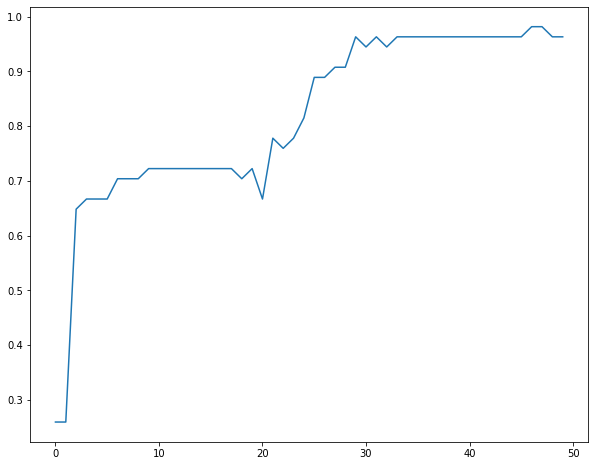

In [54]:
plt.plot(arr_loss)